In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import wordnet
from sklearn.metrics import pairwise_distances_argmin_min
import re
import numpy as np

In [ ]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv("/content/marathi_ag.csv")


In [ ]:
# Load stopwords from the provided stopwords file
with open('/content/stopwords-mr.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

lemmatizer = WordNetLemmatizer()


In [ ]:
# Regular expression pattern to match Twitter hashtag
pattern = r'"#\w+", "",'

# Function to remove Twitter hashtags from text
def remove_twitter_hashtags(tweet):
    return re.sub(pattern, '', tweet)

# Apply the function to each element in the 'text' column
df['tweet'] = df['tweet'].apply(remove_twitter_hashtags)


In [ ]:
# Define the pattern correctly
pattern = r"http[s]?://\S+"

def remove_twitter_hyperlinks(tweet):
    return re.sub(pattern, '', tweet)

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(remove_twitter_hyperlinks)

In [ ]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', ' ', tweet)  # remove http links
    tweet = re.sub(r'bit.ly/\S+', ' ', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')  # remove [links]
    # Remove unwanted characters
    tweet = re.sub('<.*?>+', '', tweet)  # remove HTML tags
    tweet = re.sub('@\S+', '', tweet)  # remove mentions
    tweet = re.sub('#', '', tweet)  # remove hashtags
    tweet = re.sub(pattern, '', tweet)  # remove unwanted characters
    tweet = re.sub(r"[^\u0900-\u097Fa-zA-Z0-9\s]", "", tweet)
    return tweet

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(clean_tweet)

In [ ]:
# Define the pattern for emojis
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)

def remove_emojis(tweet):
    return emoji_pattern.sub(r'', tweet)

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(remove_emojis)

In [ ]:
def preprocess(text):

       # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize, remove stopwords, and non-alphanumeric tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords and word.isalnum()]
    # Join tokens back to string
    return ' '.join(tokens)



In [ ]:
# Preprocess the documents
documents = df['tweet'].dropna().tolist()[:16000]  # Drop NaNs and limit to 16000 rows
processed_docs = [preprocess(doc) for doc in documents]


In [ ]:
# Use Count Vectorizer
count_vectorizer = CountVectorizer(max_df=0.90, min_df=10, stop_words=None)
count_data = count_vectorizer.fit_transform(processed_docs)


In [ ]:
# Define the LDA model
lda_model = LDA(random_state=42)

# Define the search parameters
search_params = {
    'n_components': [5, 10, 15, 20],
    'learning_decay': [0.5, 0.7, 0.9]
}

In [ ]:
# Perform Grid Search
grid_search = GridSearchCV(lda_model, param_grid=search_params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(count_data)

# Best LDA model
best_lda_model = grid_search.best_estimator_



Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Apply best LDA model
lda_W = best_lda_model.transform(count_data)
lda_H = best_lda_model.components_


In [ ]:
# Get the topics and their words
feature_names = count_vectorizer.get_feature_names_out()


In [ ]:
def display_topics(H, W, feature_names, documents, num_top_words=10, num_top_documents=5):
    for topic_idx, topic in enumerate(H):
        print(f"\nTopic {topic_idx}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print("Top words:", ", ".join(top_words))
        top_doc_indices = W[:, topic_idx].argsort()[::-1][:num_top_documents]
        for i, doc_index in enumerate(top_doc_indices):
            print(f"Document {i+1}: {documents[doc_index]}")

display_topics(lda_H, lda_W, feature_names, processed_docs)



Topic 0:
Top words: 2019, maharashtra, ut, people, mandate, stole, pawar, saheb, लवकर, असत
Document 1: But Pawar saheb stole Maharashtra people mandate UT 2019 श
Document 2: But Pawar saheb stole Maharashtra people mandate UT 2019
Document 3: But Pawar saheb stole Maharashtra people mandate UT 2019
Document 4: But Pawar saheb stole Maharashtra people mandate UT 2019
Document 5: But Pawar saheb stole Maharashtra people mandate UT 2019

Topic 1:
Top words: जय, परत, मदत, बस, बर, eknathshinde, आग, एकदम, video, lokmat
Document 1: जय जय जय जय जय जय
Document 2: जय जय जय
Document 3: जय जय जय
Document 4: जय जय जय
Document 5: जय जय जय

Topic 2:
Top words: आपण, kashmiripandits, kashmirfiles, thekashmirfiles, shivsena, kashmirihindus, kashmir, sanjayraut, breaking, शपथ
Document 1: दम TheKashmiriFiles KashmirFiles KashmirGenocide KashmiriHindus KashmiriPandit TaxFreeTheKashmirFiles
Document 2: पकड KashmiriPandits KashmirFiles Shivsena BalasahebThackeray tv9marathi
Document 3: KashmiriPandits TheKa

In [ ]:
# Plot word clouds for top 10 topics
def plot_wordcloud(H, feature_names, topic_idx):
    topic = H[topic_idx]
    words = {feature_names[i]: topic[i] for i in topic.argsort()[:-21:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()


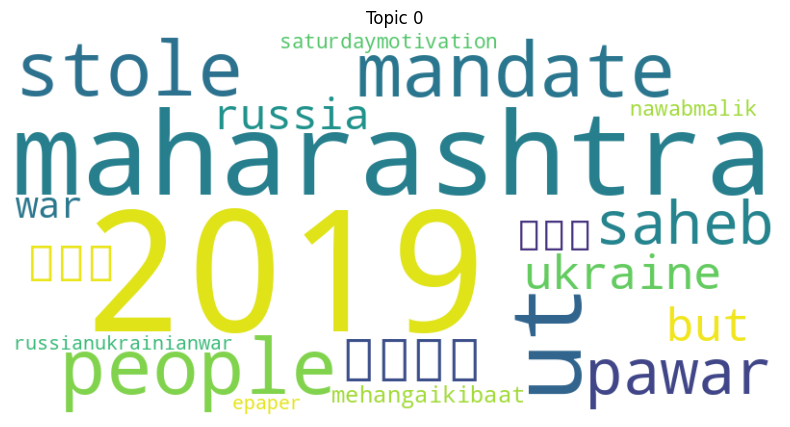

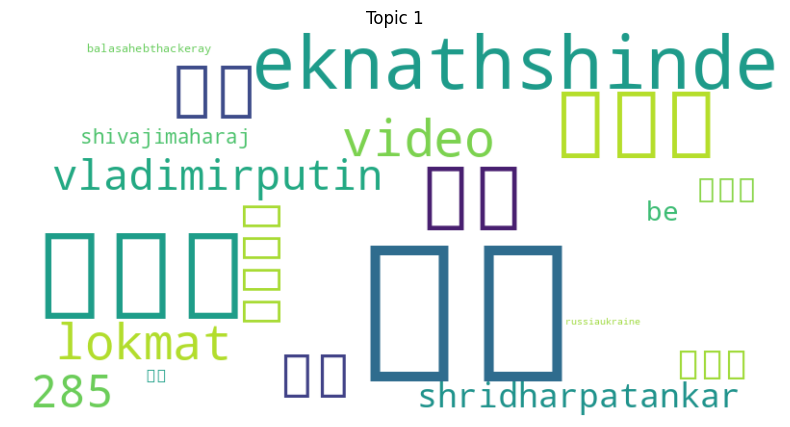

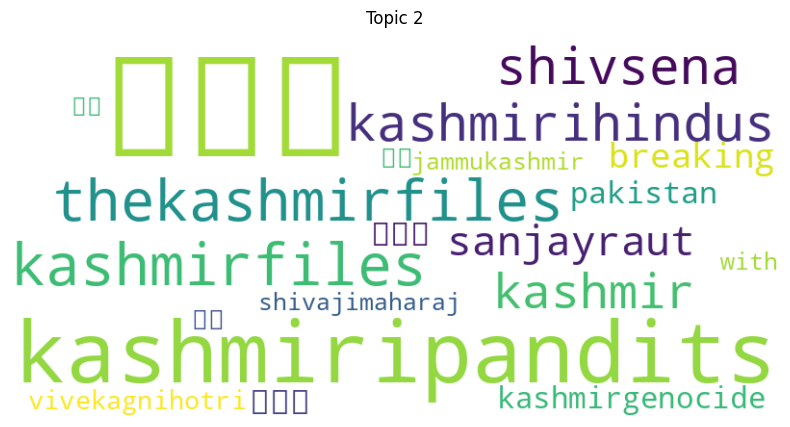

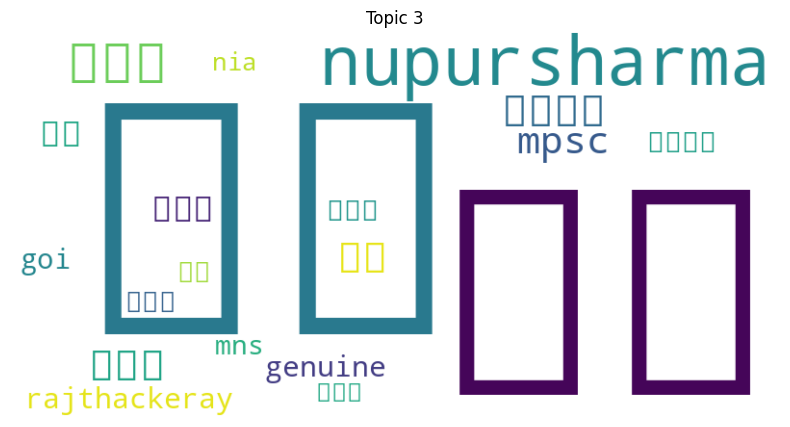

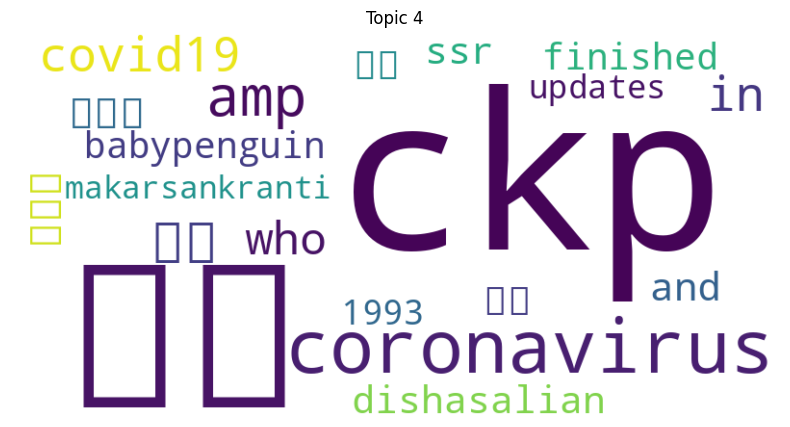

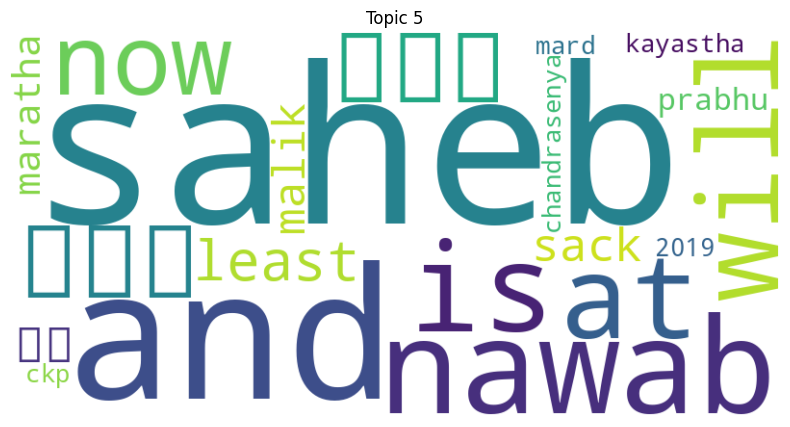

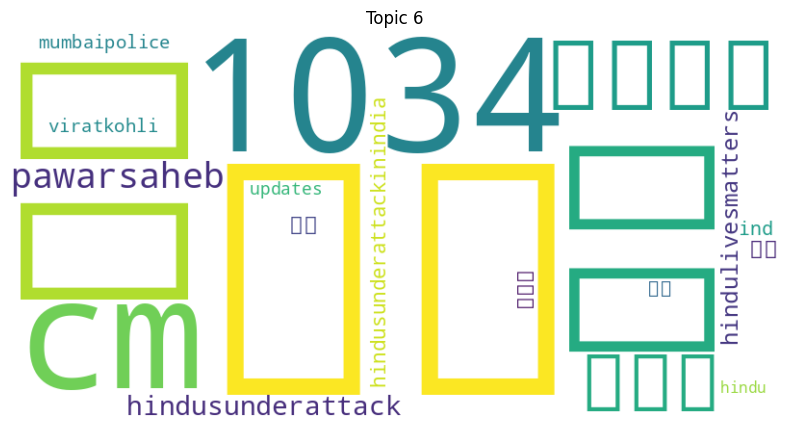

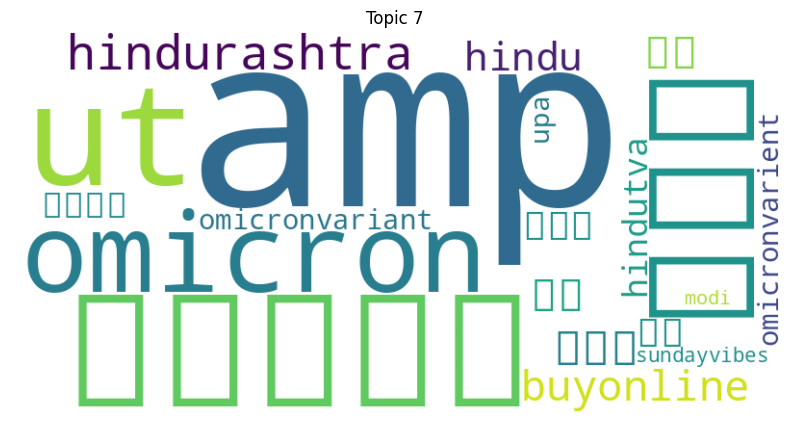

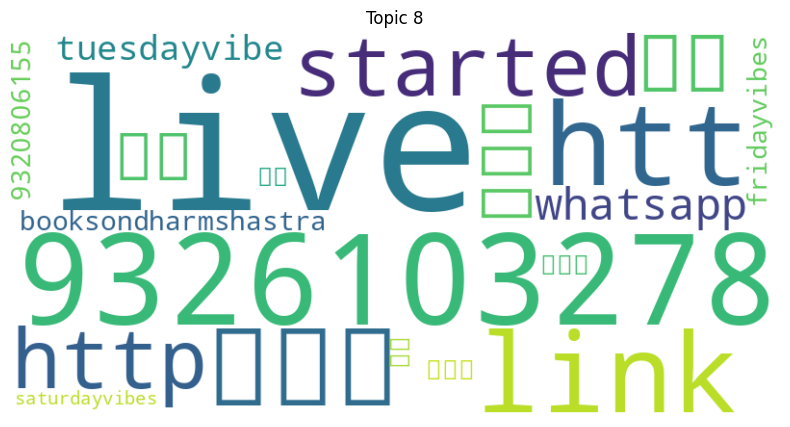

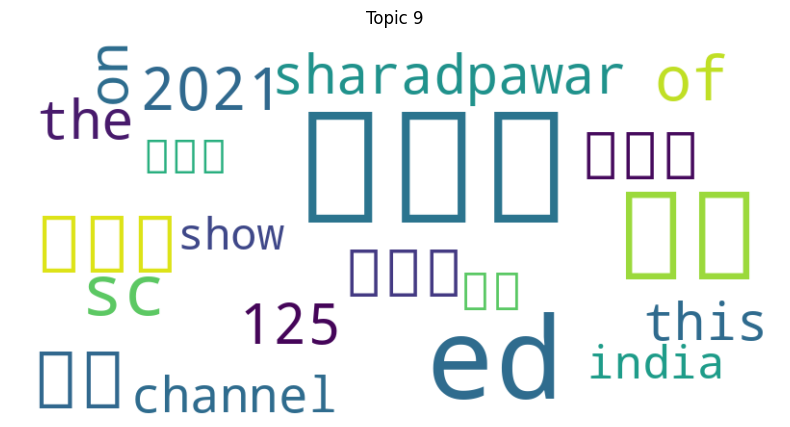

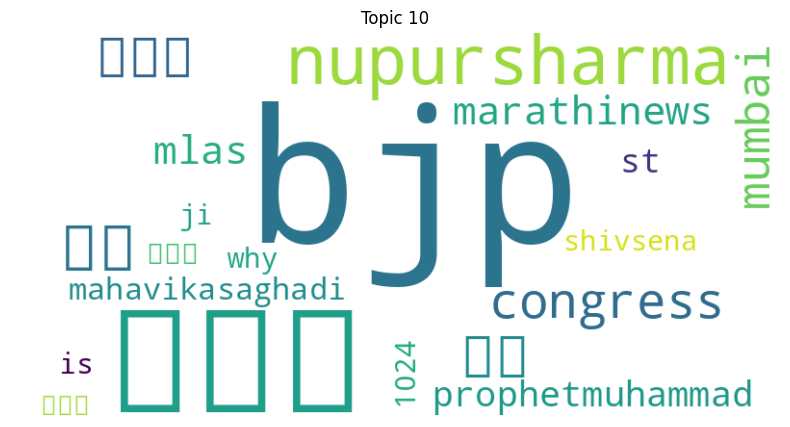

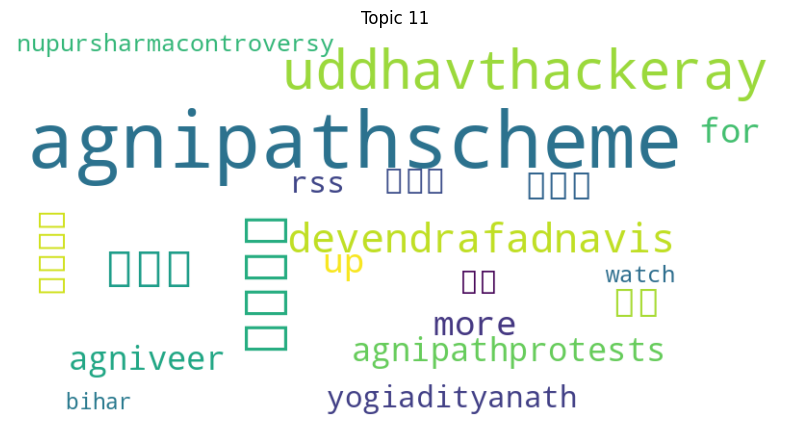

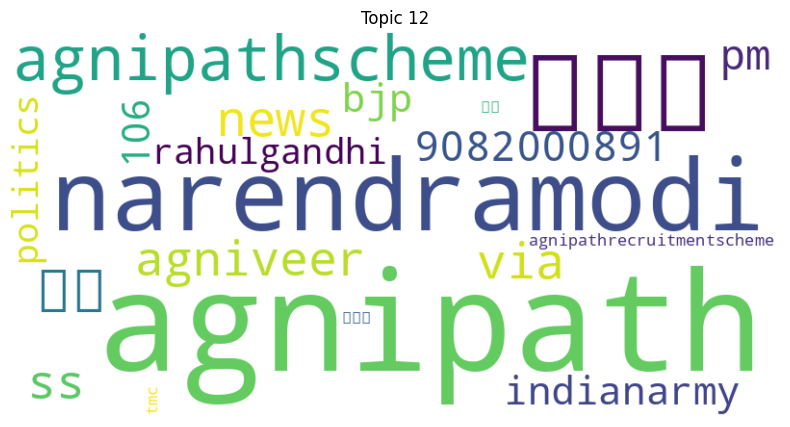

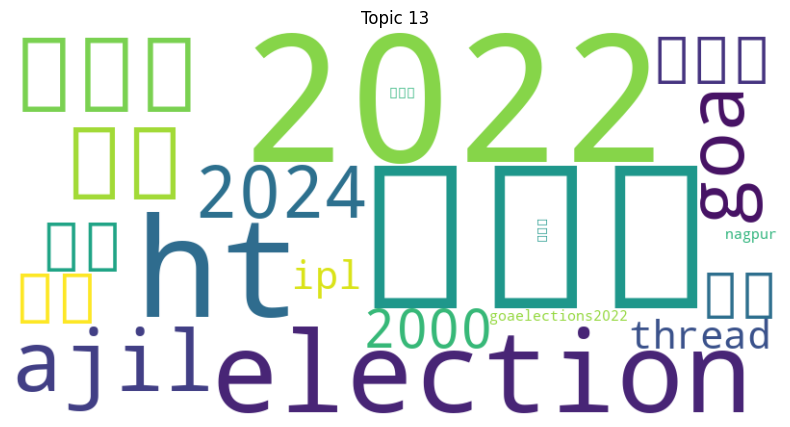

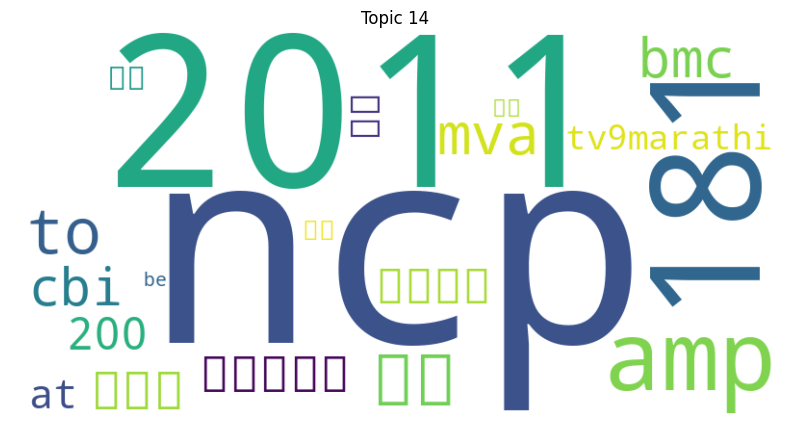

In [ ]:
# Plot word clouds for top 10 topics
for i in range(grid_search.best_params_['n_components']):
    plot_wordcloud(lda_H, feature_names, i)


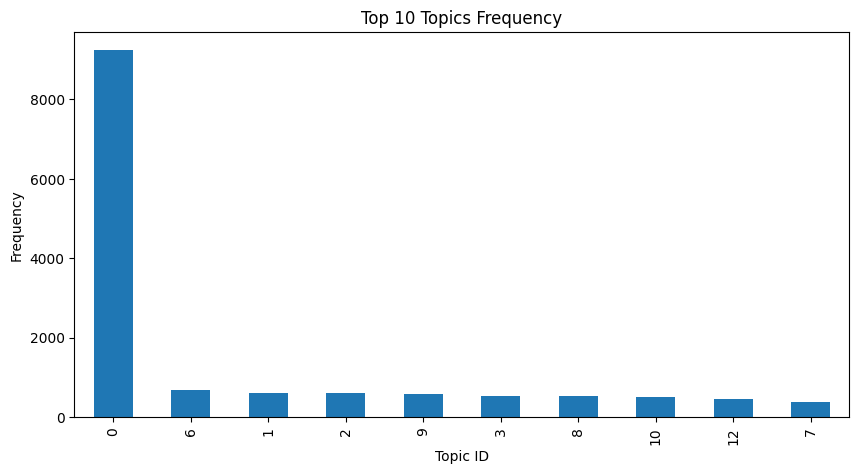

In [ ]:
# Plot the top 10 topics frequency
topic_counts = lda_W.argmax(axis=1)
topic_counts_series = pd.Series(topic_counts).value_counts()

plt.figure(figsize=(10, 5))
topic_counts_series[:10].plot(kind='bar')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.title('Top 10 Topics Frequency')
plt.show()


In [ ]:
# Print the topic labels
for i, topic in enumerate(lda_H):
    words = ', '.join([feature_names[j] for j in topic.argsort()[:-11:-1]])
    print(f"Topic {i}: {words}")



Topic 0: 2019, maharashtra, ut, people, mandate, stole, pawar, saheb, लवकर, असत
Topic 1: जय, परत, मदत, बस, बर, eknathshinde, आग, एकदम, video, lokmat
Topic 2: आपण, kashmiripandits, kashmirfiles, thekashmirfiles, shivsena, kashmirihindus, kashmir, sanjayraut, breaking, शपथ
Topic 3: हर, आई, nupursharma, परब, आयकर, कदम, मन, mpsc, ओळख, गट
Topic 4: ckp, पद, coronavirus, आई, amp, in, covid19, who, बदल, जवळ
Topic 5: saheb, and, nawab, is, at, will, एकर, now, १४७, least
Topic 6: मग, वर, ऊस, 1034, cm, १०००, नमन, pawarsaheb, hindusunderattack, आह
Topic 7: amp, लवकरच, एकच, ut, omicron, hindurashtra, सरळ, आर, यश, buyonline
Topic 8: live, 9326103278, htt, link, नगर, started, http, अस, गरज, वर
Topic 9: शरद, जर, ed, जनक, दर, sc, औषध, इतर, of, 2021
Topic 10: bjp, आजच, nupursharma, मत, सर, उघड, congress, mumbai, marathinews, mlas
Topic 11: agnipathscheme, २०२२, uddhavthackeray, फरक, devendrafadnavis, आत, करण, आठवण, more, दखल
Topic 12: agnipath, शकत, narendramodi, agnipathscheme, बघ, via, news, ss, agniv

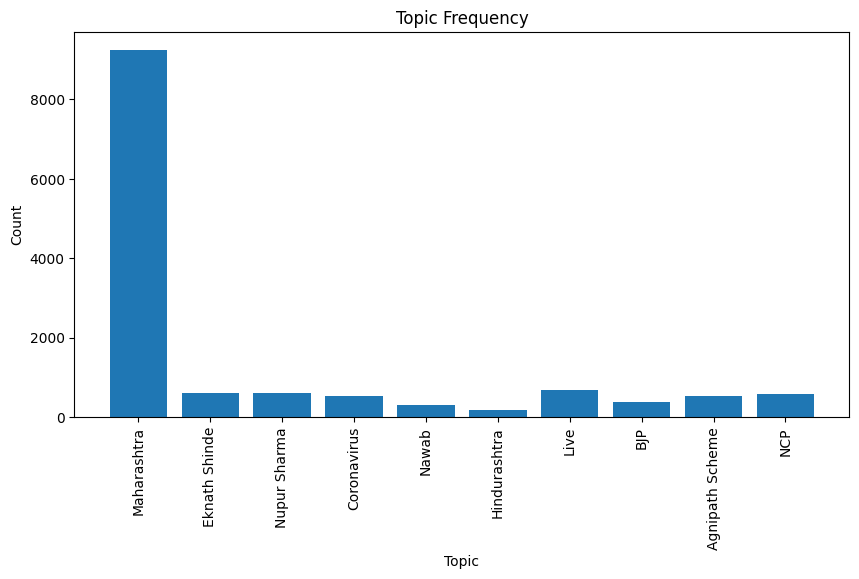

In [ ]:

topic_labels = [
    "Maharashtra",
    "Eknath Shinde",
    "Nupur Sharma",
    "Coronavirus",
    "Nawab",
    "Hindurashtra",
    "Live",
    "BJP",
    "Agnipath Scheme",
    "NCP"
]

# Get topic counts
topic_counts = lda_W.argmax(axis=1)

# Create a dictionary of topic counts
topic_counts_dict = {}
for label in topic_labels: # Initialize counts for each label
    topic_counts_dict[label] = 0

for topic in topic_counts:
    if topic < len(topic_labels): # Check if topic index is valid
        topic_counts_dict[topic_labels[topic]] += 1

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(topic_counts_dict.keys(), topic_counts_dict.values())
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Topic Frequency')
plt.xticks(rotation=90)
plt.show()